## Predicting Fit of a Clothing Item

#### Group Name

Fit 2 Stitch

 - Esther Liu
 - Sakshi Singla
 - Tian Qin

## Our Probelm

In today's world where fast fashion industry is the second most polluting industry on earth, how can we use data science to help reduce the carbon footprint this industry has created? 

Rent the Runway is a billion dollar clothing rental service that's trying to transform how women shop, we looked at their dataset to see if we can predict how a particular item on Rent the Runway will fit the customer based on past data collected for that item.

Our model hopes to help reduce the cost of shipping and returns, as well as reducing the barriers to entry for a platform like Rent the Runway.

## Our dataset

Our dataset is from the publication: 

Rishabh Misra, Mengting Wan, Julian McAuley "Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces". RecSys, 2018. https://rishabhmisra.github.io/publications/

In the Rent the Runway dataset, there's a total of 105,508 customers, 5,850 products, and 192,544 transactions.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.stats import uniform

from rfpimp import *

In [3]:
rtr = pd.read_csv('rtr_dataframe.csv')
rtr.head()

,Unnamed: 0,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


### Summary of data

#### 👗Most of the feedback falls into "fit" --> our dataset is a bit imbalanced

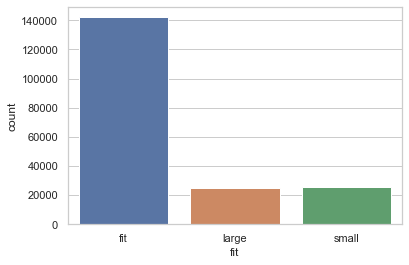

In [4]:
rtr['unique_id'] = rtr.index
fit_df = rtr.groupby('fit').agg({'unique_id': 'count'}).reset_index()
fit_df.columns = ['fit', 'count']

sns.set(style="whitegrid")
ax = sns.barplot(x="fit", y="count", data=fit_df)

#### On average women getting clothes with a smaller size tend to find them to fit large

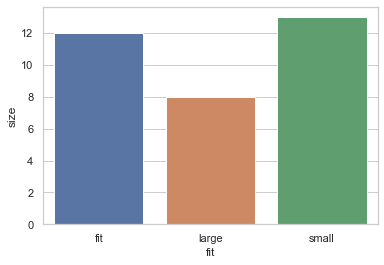

In [5]:
fit_size_df = rtr.groupby('fit').agg({'size':'median'}).reset_index()
ax = sns.barplot(x="fit", y="size", data=fit_size_df)

## Data Cleaning and Feature Engineering

#### 1) Cleaning and extracting variables to convert them to numeric values 
- Bust Size: slice out band size and cup size 
- Weight: drop 'lbs' to only keep the numeric values
- Height: extrac feet and inches 

In [6]:
def convert_bust_size(bust_size):
    """Convert bust size like 34B into a numeric value that combines band size and cup size"""
    bust_size_num=bust_size.str[:2]
    bust_size_alpha=bust_size.str[2:]
    bust_size_alpha= bust_size_alpha.map({'aa':0.5,'a':1,'b':2,'c':3,'d':4,'d+':5,'dd':6,'ddd/e':7,'f':8,'g':9,'h':10,'i':11,'j':12})
    bust_size_sum = bust_size_num.astype(int)+bust_size_alpha
    
    return bust_size_sum


def convert_height(height):
    """Convert height like 5'7 into a single numeric value in meter"""
    height_meter = height.map(lambda x: x.replace(" ", "").\
                          replace('"', "").split("'")).\
                          map(lambda x: 0.0254*(int(x[0])*12+int(x[1]))).\
                          map(lambda x: "{:.4f}".format(x))
    height_meter = height_meter.astype(float)
    return height_meter


rtr['bust_size_mod'] = convert_bust_size(rtr[~(rtr.bust_size.isna())]['bust_size'])
rtr['height'] = convert_height(rtr[~(rtr.height.isna())]['height'])

In [7]:
# Cleaning weight and slice out the 'lbs'
rtr['weight'] = rtr.weight.str.slice(0,-3)

# Convert other numeric features to float
num_features = ['rating','size','age','weight']
for features in num_features:
    rtr[features]=rtr[features].astype(float)

#### 2) Convert age to a categorical variable

In [8]:
rtr.loc[(rtr.age<20),'age_range']='Teens'
rtr.loc[((rtr.age>=20) & (rtr.age<25)),'age_range']='Early 20s'
rtr.loc[((rtr.age>=25) & (rtr.age<30)),'age_range']='Late 20s'
rtr.loc[((rtr.age>=30) & (rtr.age<40)),'age_range']='30s'
rtr.loc[(rtr.age>40),'age_range']='40s +'

#### 3) Frequency Encoding 
- item_id: do more popular clothing items tend to fit customers better?
- body_type: is it easier for more common body types to find clothes to fit?

In [9]:
def frequency_encoding(col):
    """Frequency encode the input column"""
    col_count = col.value_counts()
    return col.map(col_count)

rtr['items_count'] = frequency_encoding(rtr['item_id'])
rtr['body_type_count'] = frequency_encoding(rtr['body_type'])

#### 4) Label Encoding 

In [10]:
def df_string_to_cat(df, cat_col):
    """Convert string value of a categorical variable into ordinal variable """
    for col in cat_col:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.as_ordered()
def df_cat_to_catcode(df, cat_col):
    """Convert ordinal variable into numeric values """
    for col in cat_col:
        df[col] = df[col].cat.codes + 1

In [11]:
cat_col = ['body_type','category','item_id','rented_for','age_range']
df_string_to_cat(rtr,cat_col)
df_cat_to_catcode(rtr,cat_col)

# Modelling

### Train-test split:
  Since our "fit" data is a bit unblanced, we're doing a proper train test split here to ensure the same distribution of minortiy classes in both train set and test set. We also upsample the minority classes in the training set.

In [12]:
# Proper split to ensure 20% minority class
rtr_fit = rtr[rtr['fit']=='fit'] 
rtr_small = rtr[rtr['fit']=='small'] 
rtr_large = rtr[rtr['fit']=='large'] 

rtr_train_fit, rtr_test_fit = train_test_split(rtr_fit, test_size=0.20) 
rtr_train_small, rtr_test_small = train_test_split(rtr_small, test_size=0.20)
rtr_train_large, rtr_test_large = train_test_split(rtr_large, test_size=0.20)

rtr_train = pd.concat([rtr_train_fit, rtr_train_small,rtr_train_large], axis=0) 
rtr_test = pd.concat([rtr_test_fit, rtr_test_small,rtr_test_large], axis=0)

In [13]:
# Upsmaple the fit small and fit large data
rtr_small_balanced = rtr_train_small.sample(int(len(rtr_train_small)*2), replace=True) 
rtr_large_balanced = rtr_train_large.sample(int(len(rtr_train_large)*2), replace=True) 
rtr_train_upsampled = pd.concat([rtr_train_fit, rtr_small_balanced,rtr_large_balanced ], axis=0)

In [14]:
X_train = rtr_train_upsampled.drop(['fit'], axis=1)
X_test = rtr_test.drop(['fit'], axis=1)
y_train = rtr_train_upsampled['fit']
y_test = rtr_test['fit']

### Fit four different classification models:
- RandomForestClassifier
- GaussianNB
- KNeighborsClassifier
- LogisticRegression

In [15]:
def make_pipeline():
    "Create a single pipeline that processing the data and then fits the regressor."
    features = ['height', 'size', 'weight', 'bust_size_mod', 'body_type_count', 'rating',
                        'body_type', 'category', 'item_id', 'rented_for', 'age_range']
    transformer = Pipeline(
        steps=[('imputer', impute.SimpleImputer(strategy='median'))])
    
    preprocessor = compose.ColumnTransformer(transformers=[
        ('num', transformer, features)])

    standard_scaler = StandardScaler()
    
    rf = RandomForestClassifier(random_state=42)
    nb = GaussianNB()
    knn = KNeighborsClassifier()
    lr = LogisticRegression(random_state=42)
    
    classifier_no_scaling = [rf, nb]
    classifier_with_scaling = [knn, lr]

    pipeline = []
    for classifier in classifier_no_scaling:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', classifier)])
        pipeline.append(pipe)
        
    pipeline_with_scaling = []
    for classifier in classifier_with_scaling:
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('standard scaler', standard_scaler), 
                               ('classifier', classifier)])
        pipeline_with_scaling.append(pipe)
        
    pipeline.extend(pipeline_with_scaling)

    return pipeline

In [16]:
pipelines = make_pipeline()
# Train all the models
for pipe in pipelines:
    pipe.fit(X_train, y_train)

/Users/eliu/opt/anaconda3/envs/usf/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/eliu/opt/anaconda3/envs/usf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliu/opt/anaconda3/envs/usf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Sort our four models using both F1 score and Accuracy Score

In [144]:
def sort_models(pipelines, X_data, y_data, metric1=f1_score, metric2=accuracy_score,average='weighted'):
    """Sort models based on their f1 score."""
    scores = dict()
    for pipe in pipelines:
        y_pred = pipe.predict(X_data)
        f1_score = metric1(y_data, y_pred, average=average)
        accuracy_score = metric2(y_data, y_pred)
        classfier_name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        scores[classfier_name] = (f1_score,accuracy_score)
    scores_sorted_items = sorted(scores.items(),key=lambda x:x[1][0],reverse=True)
    scores_sorted = dict()
    for x,y  in scores_sorted_items:
        scores_sorted[x]=y

    return scores_sorted

In [145]:
sort_models(pipelines, X_train, y_train, metric1=f1_score, metric2=accuracy_score, average='weighted')

{'RandomForestClassifier': (0.993858264418591, 0.99386386314306),
 'KNeighborsClassifier': (0.7902918376105809, 0.7892008106078531),
 'GaussianNB': (0.5106674119156304, 0.6005390336484554),
 'LogisticRegression': (0.5008236923959704, 0.5967585972780858)}

### Our North Star metric: F1 score
Given that our data is unbalanced, using Accuracy as our metric wouldn't best reflect how good our model is. 
And since in terms of business value, there's not a significant difference between the false positives and false negatives here, we decided to used the balanced F1 score.

#### Based on the F1 score, we picked  RandomForestClassifier to be our model.

### Hyperparameter tuning

In [123]:
def make_random_cv(clf):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    if clf._final_estimator.__class__.__name__ == 'RandomForestClassifier':

        hyperparameters = {
            'classifier__n_estimators': [100],
            "classifier__min_samples_split": list(range(2, 6)),
            "classifier__min_samples_leaf": list(range(1, 6)),
            'classifier__max_features': list(range(1, 10))
        }

        clf_random_cv = RandomizedSearchCV(clf,
                                           hyperparameters,
                                           cv=5,
                                           n_iter=20,
                                           scoring='f1_weighted',
                                           random_state=42, n_jobs=-1)

    return clf_random_cv

In [124]:
rf = make_random_cv(pipelines[0])
rf_model = rf.fit(X_train, y_train)
print(rf_model.best_estimator_._final_estimator)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Evaluation Metric
----

#### Training set accuracy score and f1 score

In [150]:
y_pred_train_rf = rf.predict(X_train)
accuracy_score(y_train, y_pred_train_rf)
print('Training Set F1 Score for RandomForestClassfier:',round(f1_score(y_train, y_pred_train_rf, average='weighted'),4))

Training Set F1 Score for RandomForestClassfier: 0.9956


#### Test set accuracy score and f1 score

In [151]:
y_pred_test_rf = rf.predict(X_test)
print('Test Set F1 Score for RandomForestClassfier:',round(f1_score(y_test, y_pred_test_rf, average='weighted'),4))

Test Set F1 Score for RandomForestClassfier: 0.6711


## Model Results

In order to use the Random Forest Feature Importances package, we need a singe pipeline object

Since height, weight and bust size are collinear features, we group them together here to examine their feature importance

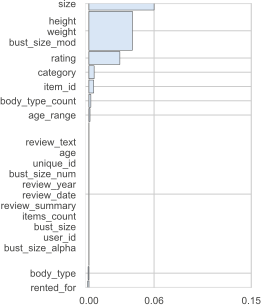

In [157]:
regressor_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

def make_pipeline(regressor=None):
    "Create a single pipeline that processing the data and then fits the regressor." 
    numeric_features = ['height','size','weight','bust_size_mod','body_type_count','rating',\
                        'body_type','category','item_id','rented_for','age_range']
    numeric_transformer = Pipeline(steps=[('imputer', impute.SimpleImputer(strategy='median'))])

    preprocessor = compose.ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('reg', regressor)])

    return pipeline

pipeline_rf = make_pipeline(regressor_rf)
pipeline_rf.fit(X_train, y_train)

I = importances(pipeline_rf, X_test, y_test, features=['size',['height','weight','bust_size_mod'],'body_type_count','rating',\
                        'body_type','category','item_id','rented_for','age_range'])
plot_importances(I)

#### When we are not grouping collinear features together, weight and height drop to the 3rd and 4th importance.

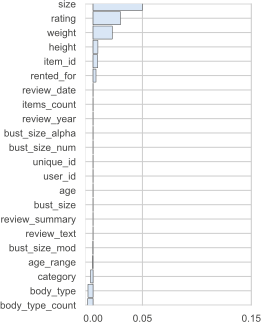

In [161]:
I = importances(pipeline_rf, X_test, y_test)
plot_importances(I)

## Takeways

- Compared to using OneHotEncoder for our categorical variable, using the combination of LabelEncoding and RandomForestClassfier has helped our model becomes a lot faster and achieves a higher F1 score. This is only valid because RandomForestClassfier does not do any calculation on variables. 

- Performing Hyperparemeter tuing is an expensive process, we should choose our models first and then use Random Search on the model.